Sports Info Solutions analytics challenge: https://github.com/ecavan/AnalyticsChallenge2021

Q: Which route combinations were most popular in the NFL in 2020? Of these route combinations, which perform best against each coverage type?

# Imports & Data

In [1]:
from IPython.core.display import display, HTML
import pandas as pd
display(HTML("<style>.container { width:100% !important; }</style>"))

desired_width = 320    
pd.set_option('display.width', desired_width)

In [2]:
import numpy as np
import scipy.stats as stats
import copy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from collections import Counter

import category_encoders as ce

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score, mean_absolute_error
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

In [3]:
plays = pd.read_csv('PlayByPlay.csv')
games = pd.read_csv('GameInfo.csv')
games = games.drop(['Week', 'Season'], axis=1)
points = pd.read_csv('PlayerTotalPoints.csv')
points=points.rename(columns = {'Name':'Name_points'})
skillpos = pd.read_csv('SkillPositionPlayers.csv')
tms = pd.read_csv('tms.csv')
rates = pd.read_csv('M21 Launch Ratings - Sheet1.csv')
rates = rates[['Name', 'archetype', 'overall_rating']]

print(rates.columns)
print(len(rates))
print(plays.columns)
print(len(plays))
print(' ')
print(games.columns)
print(len(games))
print(' ')
print(points.columns)
print(len(points))
print(' ')
print(skillpos.columns)
print(len(skillpos))
print(' ')
### from: https://www.pro-football-reference.com/years/2020/index.htm ###

print(tms.columns)

Index(['Name', 'archetype', 'overall_rating'], dtype='object')
2293
Index(['GameID', 'EventID', 'Season', 'Week', 'OffensiveTeam', 'DefensiveTeam', 'OffTeamScoreBefore', 'DefTeamScoreBefore', 'Quarter', 'TimeLeft', 'Down', 'ToGo', 'SideOfField', 'StartYard', 'Hash', 'EventType', 'FirstDown', 'Touchdown', 'Safety', 'Turnover', 'Attempt', 'Completion', 'Spike', 'ThrowAway',
       'ThrowDepth', 'Shotgun', 'DropType', 'RPO', 'CoverageScheme', 'PressureOnPlay', 'SackOnPlay', 'PassBreakupOnPlay', 'InterceptionOnPlay', 'FumbleByPasser', 'FumbleByRusher', 'FumbleByReceiver', 'OffensiveYardage', 'EPA', 'PlayDesc'],
      dtype='object')
32170
 
Index(['GameId', 'HomeTeamId', 'HomeTeam', 'AwayTeamId', 'AwayTeam', 'StadiumName', 'CoveredStadium', 'HomeScore', 'AwayScore', 'SpreadLine', 'TotalLine', 'SpreadResult', 'TotalResult', 'Weather', 'PrecipIntensity', 'PrecipProbability', 'PrecipType', 'Temperature', 'WindSpeed'], dtype='object')
256
 
Index(['GameID', 'PlayerId', 'Name_points', 'TotalPoi

In [4]:
plays_games = plays.merge(games, left_on = 'GameID', right_on = 'GameId')
plays_games_points = plays_games.merge(points, on = 'GameID')
full_df = plays_games_points.merge(skillpos, on = ['GameID', 'PlayerId', 'EventID'])
full_df = full_df.merge(tms, left_on = 'OffensiveTeam', right_on = 'Tm')
full_df = full_df.merge(rates, on ='Name', how = 'left')

# Feature Engineering & Data Cleaning

In [5]:
full_df["Route"].replace({"Screen - Shovel": "Screen", 
                          "Screen - TE": "Screen",
                          "Screen - Drag":"Screen",
                          "Screen - Beneath":"Screen",
                          "Screen - Tunnel": "Screen",
                          "Screen - Quick":"Screen",
                          "Screen - Bubble":"Screen",
                          "Screen - RB":"Screen",
                          "Flat - Left":"Flat",
                          "Chip - Flat":"Flat",
                          "Flat - Right":"Flat",
                          "Stick - Nod":"Flat",
                          "Chip - Drag":"Drag",
                          "Chip - Seam":"Seam",
                          "Chip - Curl":"Curl",
                          "Swing - Left":"Swing",
                          "Swing - Right":"Swing",
                          "Go/Fly":"Go",
                          "Hitch & Go": "Go",
                          "Out & Up": "Sluggo",
                          'Comeback':"Curl",
                          'Whip':"Flat",
                          "Dig":"Flat",
                          'Jerk':"Curl",
                          "Post Corner":"Post",
                          'Beneath':"Quick",
                          "Check & Release":"Go",
                          "Drag": 'Flat',
                          "Angle": "Slant",
                          "Leak": "Flat",
                          "Seam":"Go",
                          "Fade - Back Shoulder":"Fade"}, inplace=True)


full_df = full_df[(full_df.CoverageScheme != "Spike") & (full_df.CoverageScheme != "Other")]

In [6]:
full_df.loc[full_df['Target'] == 1, 'air_yards'] = full_df['ThrowDepth']

full_df['AYPA'] = full_df['air_yards']/full_df['Attempt']
full_df['YPA'] = full_df['OffensiveYardage']/full_df['Attempt']

full_df.loc[(full_df['SideOfField'] == 'Own')&(full_df['StartYard'] < 20), 'FieldPosition'] = 'EZ'
full_df.loc[(full_df['SideOfField'] == 'Oppo')&(full_df['StartYard'] < 20), 'FieldPosition'] = 'RZ'
full_df.loc[(full_df['StartYard'] > 20), 'FieldPosition'] = 'Mid'

full_df_target = full_df[full_df.Target ==  1]
full_df_target = full_df_target[full_df_target.groupby('Route')['Route'].transform('size') > 39]

gb_routes = full_df_target.groupby('Route', dropna=False)['air_yards'].mean().reset_index()
kmeans = KMeans(n_clusters=3)
kmeans.fit(gb_routes['air_yards'].values.reshape(-1,1))
y_kmeans = kmeans.predict(gb_routes['air_yards'].values.reshape(-1,1))

long = gb_routes[gb_routes.air_yards > 20]['Route'].to_list()
medium = gb_routes[(gb_routes.air_yards < 20) & (gb_routes.air_yards >= 10)]['Route'].to_list()
short = gb_routes[(gb_routes.air_yards < 10) & (gb_routes.air_yards >= -0.5)]['Route'].to_list()
screen = gb_routes[gb_routes.air_yards < -0.5]['Route'].to_list()
rpo = full_df[(full_df.RPO == 1)&(full_df.Target == 1)].index.to_list()

full_df.loc[full_df['Route'].isin(long), 'route_len'] = 'Long'
full_df.loc[full_df['Route'].isin(medium), 'route_len'] = 'Medium'
full_df.loc[full_df['Route'].isin(short), 'route_len'] = 'Short'
full_df.loc[full_df['Route'].isin(screen), 'route_len'] = 'Screen'
full_df.loc[full_df.index.isin(rpo), 'Route'] = 'rpo'

rpo_list = full_df[full_df.Route == 'rpo']['Route'].to_list()

Kmeans plot of all routes clustered into classes: long, medium, short and screen routes (this is done to easily distinguish between the variety of routes available). I will use the classes of routes for key calculations and then refer to the routes that are best in their given class (i.e the best short routes, the best medium routes, ect) to make predictions using the machine learning models (Expected points, probability of a first down). 

Note: I used 3 clusters, but took any routes with air yards < -0.5 to be considered screens.

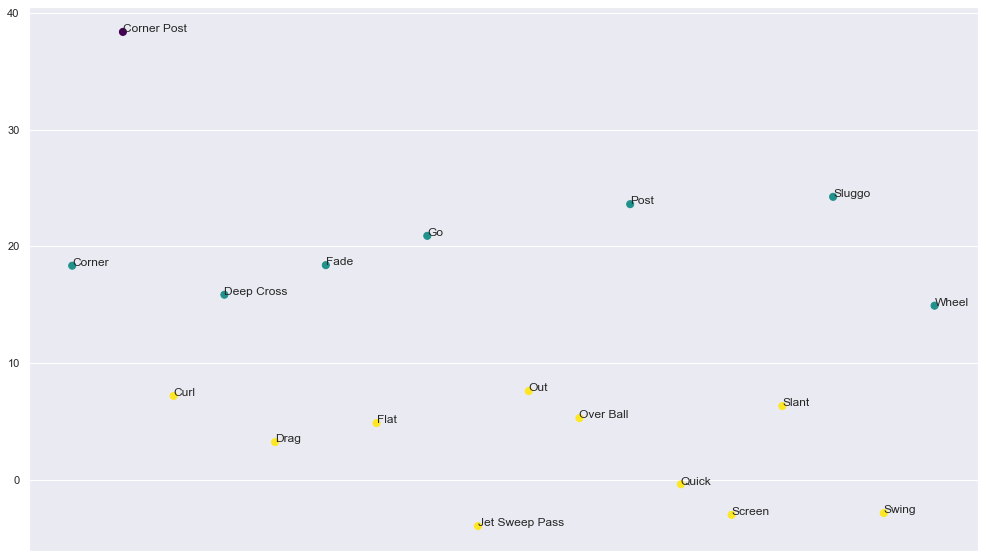

In [7]:
plt.rcParams["figure.figsize"] = (17,10)
plt.scatter(gb_routes['Route'], gb_routes['air_yards'], c=y_kmeans, s=50, cmap='viridis')
plt.xticks([]);

for i, txt in enumerate(gb_routes['Route']):
    plt.annotate(txt, (gb_routes['Route'][i], gb_routes['air_yards'][i]))   

In [8]:
full_df_catch = full_df[full_df.Completion == 1]
full_df['YAC'] = full_df_catch.OffensiveYardage - full_df_catch.ThrowDepth

full_df['YAC_per_cov'] = full_df.groupby('CoverageScheme', dropna=False)['YAC'].transform('mean')

pressure_df = (full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['PressureOnPlay'].sum()/full_df.groupby('DefensiveTeam')['CoverageScheme'].size()).reset_index(name = 'pressure_rate_per_coverage')
breakup_df = ((full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['PassBreakupOnPlay'].sum() + full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['ThrowAway'].sum() )/full_df.groupby('DefensiveTeam')['CoverageScheme'].size()).reset_index(name = 'breakup_rate_per_coverage')
target_df = (full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['Target'].sum()/full_df.groupby('DefensiveTeam')['CoverageScheme'].size()).reset_index(name = 'target_rate_per_coverage')
fd_df = (full_df.groupby(['CoverageScheme', 'DefensiveTeam'])['FirstDown'].sum()/full_df.groupby('DefensiveTeam')['CoverageScheme'].size()).reset_index(name = 'firstdown_rate_per_coverage')

fm_df = (full_df.groupby(['OffensiveTeam'])['FastMotion'].sum()/full_df.groupby('OffensiveTeam')['CoverageScheme'].size()).reset_index(name = 'motion_rate_per_coverage')

full_df = full_df.merge(breakup_df, on = ['CoverageScheme', 'DefensiveTeam'])
full_df = full_df.merge(pressure_df, on = ['CoverageScheme', 'DefensiveTeam'])
full_df = full_df.merge(target_df, on = ['CoverageScheme', 'DefensiveTeam'])
full_df = full_df.merge(fd_df, on = ['CoverageScheme', 'DefensiveTeam'])
full_df = full_df.merge(fm_df, on = 'OffensiveTeam')

Obviously having a greater QB throwing the ball or having a better receiver on the end of that throw matters. I used the Total_Points feature from SIS to create a meature which determines how much better a player like Tom Brady is compared to the average QB (Points above Average, instead of Points above replacement, since I had no idea how a replacement level QB should preform). I didn't include players with less than 300 snaps so that they would not influence the calculation of the mean. 

In [9]:
snaps = full_df.groupby(['RosterPosition', 'Name'])['Name'].size().reset_index(name = 'snaps')
full_df = full_df.merge(snaps, on =['RosterPosition', 'Name'])
full_df = full_df[full_df.snaps > 50]

full_df['Average_points'] = full_df.groupby('RosterPosition')['TotalPoints'].transform('mean')
full_df['PAA'] = (full_df.groupby('Name')['TotalPoints'].transform('mean') - full_df['Average_points'])/full_df['Average_points']


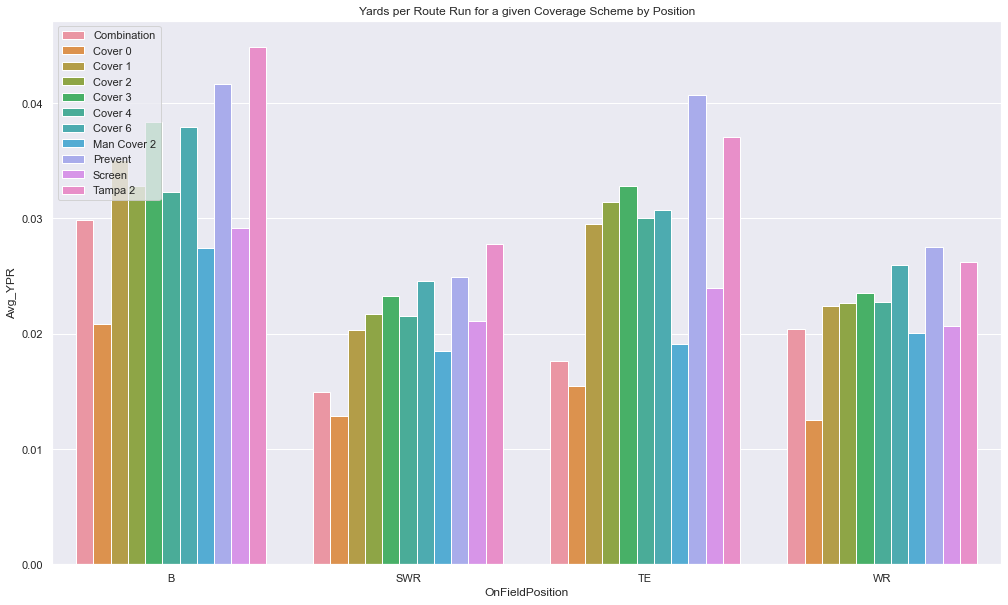

In [10]:
full_df['Yards_per_route'] = full_df['OffensiveYardage']/full_df['snaps']
full_df_noqb = full_df[full_df.OnFieldPosition != 'QB']
gb = (full_df_noqb.groupby(['OnFieldPosition', "CoverageScheme" ])['air_yards'].sum()/full_df_noqb.groupby(['OnFieldPosition', "CoverageScheme" ])['Attempt'].sum()).reset_index(name = 'APA')

gb_ybr = full_df_noqb.groupby(['OnFieldPosition', "CoverageScheme" ])['Yards_per_route'].mean().reset_index(name = 'Avg_YPR')

sns.barplot(x='OnFieldPosition', y='Avg_YPR', hue="CoverageScheme", data=gb_ybr);
plt.title('Yards per Route Run for a given Coverage Scheme by Position');
plt.legend(loc='upper left');

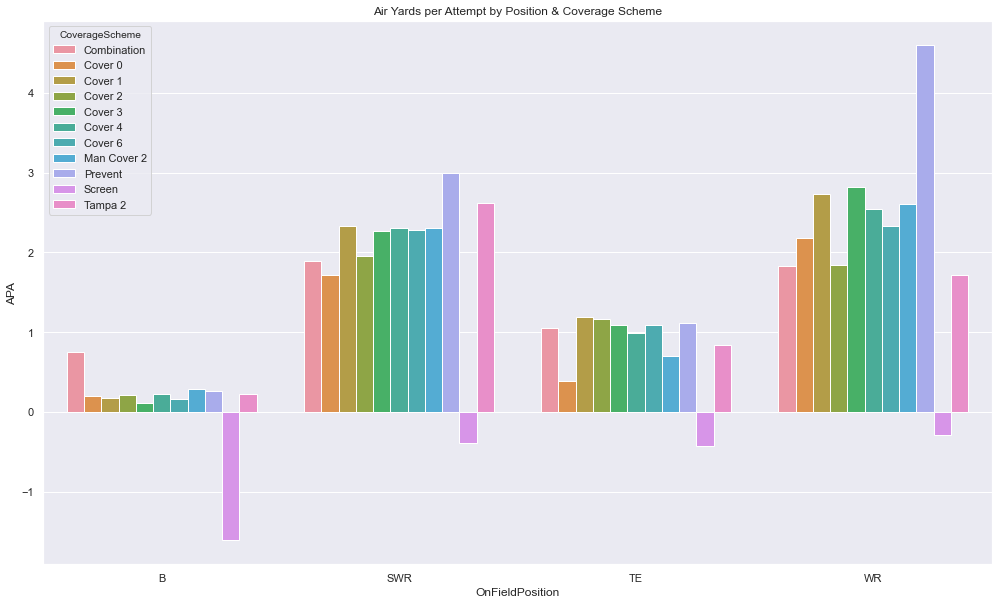

In [11]:
sns.barplot(x='OnFieldPosition', y='APA', hue = "CoverageScheme", data=gb);
plt.title('Air Yards per Attempt by Position & Coverage Scheme');

Sample of High Preforming QBs
 
['Deshaun Watson' 'Matt Ryan' 'Josh Allen' 'Derek Carr'
 'Teddy Bridgewater' 'Justin Herbert' 'Drew Brees' 'Tom Brady'
 'Patrick Mahomes' 'Philip Rivers' 'Joe Burrow' 'Ryan Tannehill'
 'Russell Wilson' 'Matthew Stafford' 'Aaron Rodgers' 'Kirk Cousins'
 'Kyler Murray']
 
Top QBs in Madden
 
                  Name RosterPosition  overall_rating
47988  Patrick Mahomes             QB            99.0
88905   Russell Wilson             QB            97.0
8196     Lamar Jackson             QB            94.0
37265       Drew Brees             QB            93.0
41624        Tom Brady             QB            90.0


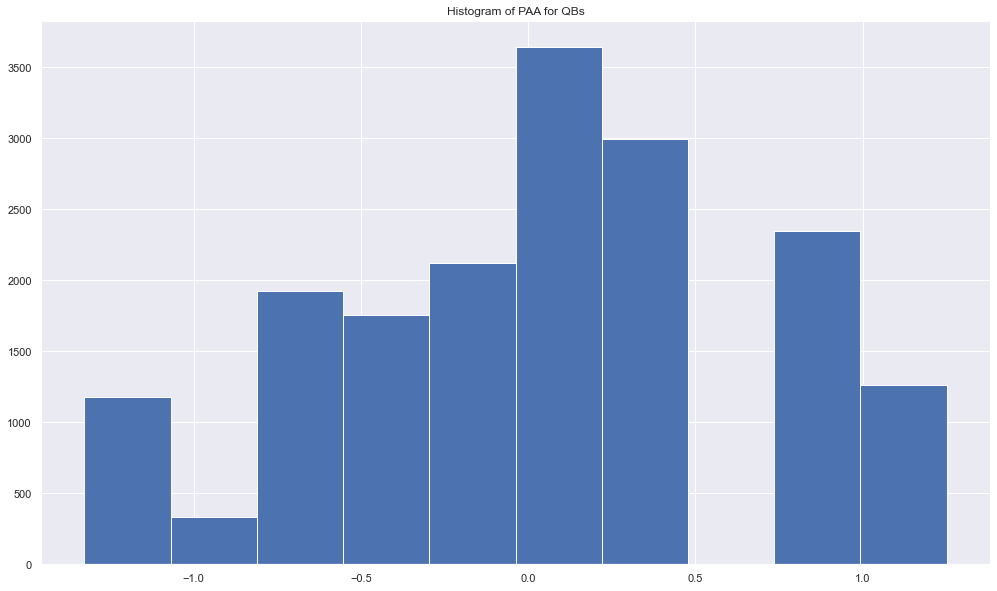

Sample of High Preforming WRs
 
['Calvin Ridley' 'Julio Jones' 'Stefon Diggs' 'Cole Beasley'
 'Keenan Allen' 'Michael Thomas' 'Tyreek Hill' 'Jarvis Landry'
 'Corey Davis' 'Davante Adams' 'Justin Jefferson' 'Brandon Aiyuk'
 'DeAndre Hopkins' 'Cooper Kupp']
 
Top WRs in Madden
 
                   Name RosterPosition  overall_rating
39669    Michael Thomas             WR            99.0
110383  DeAndre Hopkins             WR            98.0
7592        Julio Jones             WR            97.0
48868       Tyreek Hill             WR            96.0
101045    Davante Adams             WR            94.0


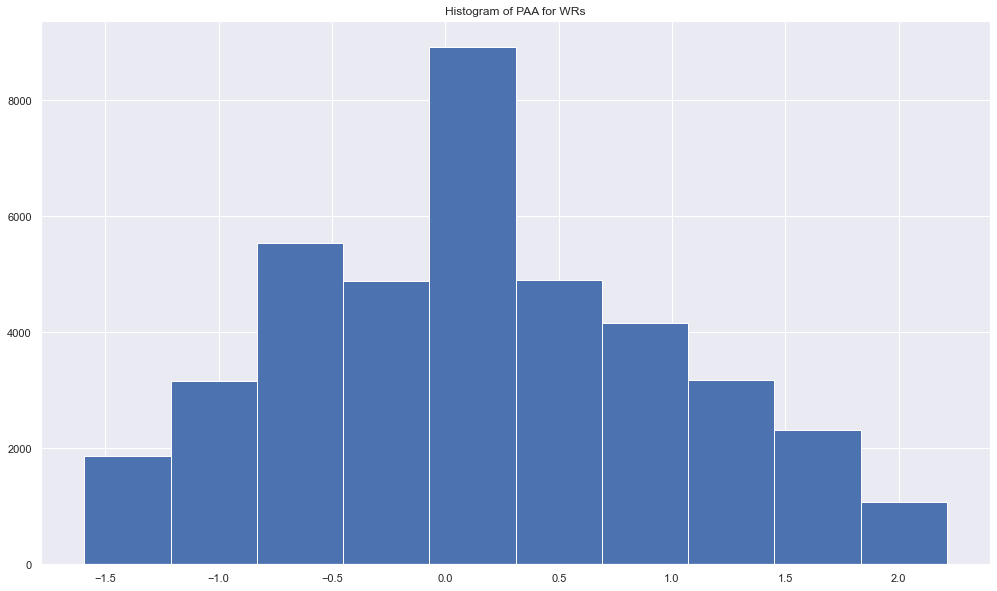

In [12]:
###sample players###
full_df_wr = full_df[(full_df.RosterPosition == 'WR')&(full_df.snaps > 250)]
full_df_qb = full_df[(full_df.RosterPosition == 'QB')&(full_df.snaps > 250)]

madden_df = pd.DataFrame(full_df.sort_values('overall_rating', ascending = False))
madden_df = madden_df[['Name', 'RosterPosition','overall_rating']]
madden_df.drop_duplicates(keep = 'first', inplace=True)

print('Sample of High Preforming QBs')
print(' ')
print(full_df_qb[full_df_qb.PAA > 0]['Name'].unique())
print(' ')
madden_df_qb = madden_df[madden_df.RosterPosition == 'QB']
print('Top QBs in Madden')
print(' ')
print(madden_df_qb[0:5])

plt.hist(full_df_qb['PAA']);
plt.title('Histogram of PAA for QBs')
plt.show()

print('Sample of High Preforming WRs')
print(' ')
print(full_df_wr[full_df_wr.PAA > 1]['Name'].unique())
print( ' ')
madden_df_wr = madden_df[madden_df.RosterPosition == 'WR']
print('Top WRs in Madden')
print(' ')
print(madden_df_wr[0:5])

plt.hist(full_df_wr['PAA']);
plt.title('Histogram of PAA for WRs')
plt.show()

Next, I wanted to classify players based on their specialities with the routes they run. i.e a player like Tyreek Hill would have a speciality as a player who is exceptional at running 'Long' routes like Streaks and Corner Post routes. The best receivers (like Tyreek Hill) may be classified as a specialist with multipe route types. The idea is if you are a specialist as a short route receiver, you are worth more running a short route compared to a long route.

In [13]:
player_type = full_df.groupby(['Name', 'route_len'])['EPA'].agg(['mean', 'count']).reset_index()

mean_len_long = np.mean(player_type[player_type.route_len == 'Long']['count'])
mean_len_med = np.mean(player_type[player_type.route_len == 'Medium']['count'])
mean_len_short = np.mean(player_type[player_type.route_len == 'Short']['count'])
mean_len_screen = np.mean(player_type[player_type.route_len == 'Screen']['count'])

mean_epa_long = np.mean(player_type[player_type.route_len == 'Long']['mean'])
mean_epa_med = np.mean(player_type[player_type.route_len == 'Medium']['mean'])
mean_epa_short = np.mean(player_type[player_type.route_len == 'Short']['mean'])
mean_epa_screen = np.mean(player_type[player_type.route_len == 'Screen']['mean'])

player_type['Classify'] = np.nan

player_type.loc[(player_type.route_len == 'Long')&(player_type['mean'] >= 1.5*mean_epa_long)&(player_type['count'] >= 1.2*mean_len_long), 'Classify'] = 'Long'
player_type.loc[(player_type.route_len == 'Short')&(player_type['mean'] >= 1.5*mean_epa_short)&(player_type['count'] >= 1.2*mean_len_short), 'Classify'] = 'Short'
player_type.loc[(player_type.route_len == 'Medium')&(player_type['mean'] >= 1.5*mean_epa_med)&(player_type['count'] >= 1.2*mean_len_med), 'Classify'] = 'Medium'
player_type.loc[(player_type.route_len == 'Screen')&(player_type['mean'] >= 1.5*mean_epa_screen)&(player_type['count'] >= 1.2*mean_len_screen), 'Classify'] = 'Screen'

player_type = player_type.dropna()
gb = player_type.groupby('Name')['Classify'].unique().reset_index(name = 'receiver_class')

full_df = full_df.merge(gb, on = 'Name', how = 'left')
full_df['receiver_class'] = full_df['receiver_class'].fillna('None')

##A bool which determines if a player (or multiple players) are running a specialized route on the play##
full_df['Running_specialized_route'] = full_df.apply(lambda x: str(x['route_len']) in x['receiver_class'], axis=1)


Are slot receivers better than wideouts for certain schemes?

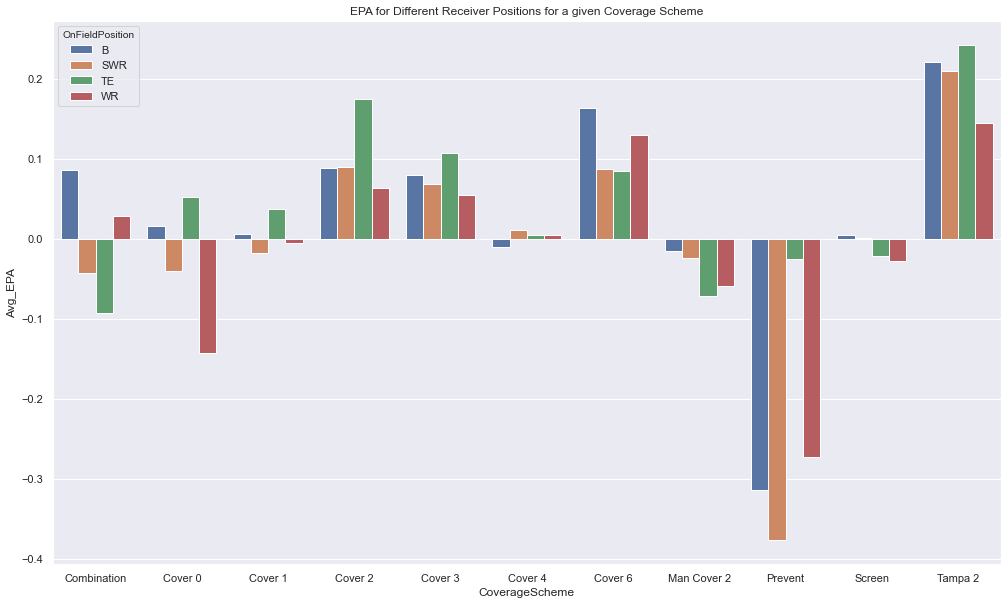

In [14]:
gb_pos = full_df_noqb.groupby(['CoverageScheme','OnFieldPosition' ])['EPA'].mean().reset_index(name = 'Avg_EPA')

sns.barplot(x="CoverageScheme", y='Avg_EPA', hue='OnFieldPosition', data=gb_pos);
plt.title('EPA for Different Receiver Positions for a given Coverage Scheme');

# Most Popular Route Combinations

The first part of the question asks what are the most popular route combinations, we answer this questiom in the following cells.

First: Get Personnel Groupings

In [15]:
pos_df = full_df.groupby(['GameID', 'EventID'])['OnFieldPosition'].apply(list).reset_index()
pos_df.columns = ['GameID', 'EventID', 'position']

full_df = full_df.merge(pos_df, on =['GameID', 'EventID'])
full_df['position'] = full_df['position'].sort_values().apply(lambda x: sorted(x))

full_df['QB_in_play'] = full_df.apply(lambda x: "QB" in x['position'], axis=1)

full_df = full_df[full_df['QB_in_play']]

full_df['num_B'] = full_df.apply(lambda x: x['position'].count("B"), axis=1)
full_df['num_TE'] = full_df.apply(lambda x: x['position'].count("TE"), axis=1)

full_df.loc[(full_df.num_TE == 2) & (full_df.num_B == 1), 'personnel'] = "12"
full_df.loc[(full_df.num_TE == 2) & (full_df.num_B == 0), 'personnel'] = '2'
full_df.loc[(full_df.num_TE == 1) & (full_df.num_B == 2), 'personnel'] = '21'
full_df.loc[(full_df.num_TE == 2) & (full_df.num_B == 2), 'personnel'] = '22'
full_df.loc[(full_df.num_TE == 1) & (full_df.num_B == 1), 'personnel'] = '11'
full_df.loc[(full_df.num_TE == 0) & (full_df.num_B == 1), 'personnel'] = '10'
full_df.loc[(full_df.num_TE == 3) & (full_df.num_B == 2), 'personnel'] = '23'
full_df.loc[(full_df.num_TE == 0) & (full_df.num_B == 0), 'personnel'] = '0'
full_df.loc[(full_df.num_TE == 1) & (full_df.num_B == 0), 'personnel'] = '1'
full_df.loc[(full_df.num_TE == 3) & (full_df.num_B == 1), 'personnel'] = '13'
full_df.loc[(full_df.num_TE == 0) & (full_df.num_B == 2), 'personnel'] = '12'

###10 personnel is the most common formation####

full_df.personnel.value_counts()

10    35399
11    32956
12    15504
0     12992
1      4806
21     3078
13     2774
2      1298
22      485
23       43
Name: personnel, dtype: int64

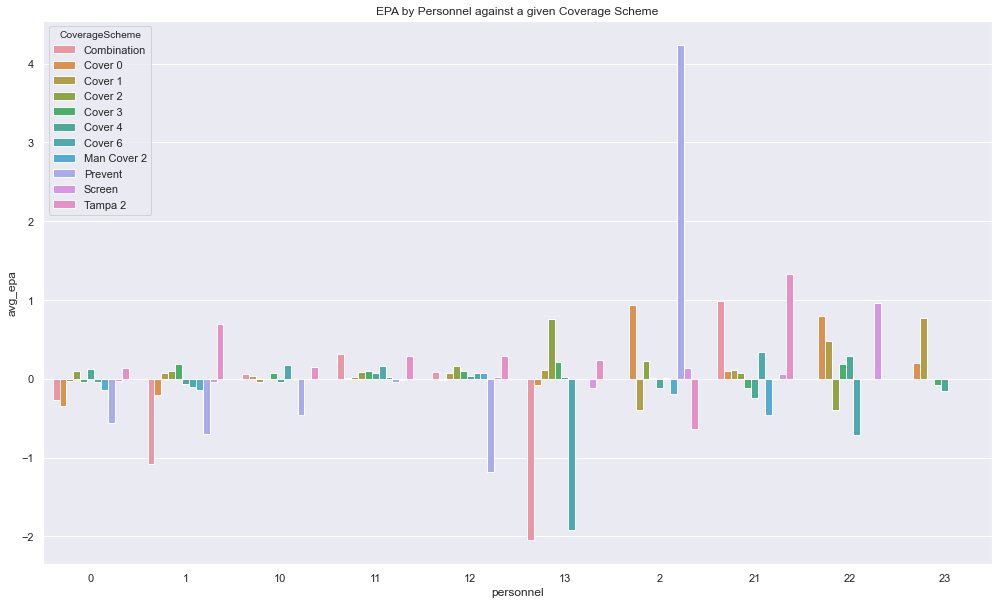

In [16]:
gb_p = full_df.groupby(['personnel', "CoverageScheme"])['EPA'].mean().reset_index(name = 'avg_epa')

sns.barplot(x="personnel", y='avg_epa', hue='CoverageScheme', data=gb_p);
plt.title('EPA by Personnel against a given Coverage Scheme');

In [17]:
full_df['Route'] = full_df['Route'].fillna('Blocking')

full_df_with_block = full_df.copy()
full_df = full_df[full_df['Route'] != 'Blocking']

route_df = full_df.groupby(['GameID', 'EventID'])['Route'].apply(list).reset_index()
route_df.columns = ['GameID', 'EventID', 'Route_list']

full_df = full_df.merge(route_df, on =['GameID', 'EventID'])

Because there are so many combinations of possible routes, I chose to look at the combinations of route lengths; and then pick the best routes to replace the route lengths (i.e chose curl to replace a short route since it has the highest EPA for all short routes).

In [18]:
route_list = full_df['Route_list'].tolist()

route_list2 = copy.deepcopy(route_list)

for i, x in enumerate(route_list2):
    for j, a in enumerate(x):
        if a in short:
            route_list2[i][j] = 'short'
        elif a in long:
            route_list2[i][j] = 'long'
        elif a in medium:
            route_list2[i][j] = 'medium'
        elif a in screen:
            route_list2[i][j] = 'screen'
        elif a in rpo_list:
            route_list2[i][j] = 'rpo'

route_list_sort = []
for i in route_list2:
    route_list_sort.append(sorted(i))
    
c = Counter(map(tuple,route_list_sort))

routes_counted = [(l,k/len(l)) for k,l in sorted([(j,i) for i,j in c.items()], reverse=True)]

full_df['Route_list'] = full_df['Route_list'].sort_values().apply(lambda x: sorted(x))

print('Most popular route combinations by route length: ')
print('')
print(routes_counted[0])
print(routes_counted[1])
print(routes_counted[2])
print(routes_counted[3])
print(routes_counted[4])
print(routes_counted[5])

full_df.insert(104, 'route_len_list', route_list_sort)
full_df['route_len_list' ] = full_df['route_len_list' ].astype(str)

Most popular route combinations by route length: 

(('long', 'short', 'short', 'short', 'short'), 1285.0)
(('short', 'short', 'short', 'short', 'short'), 1083.0)
(('medium', 'short', 'short', 'short', 'short'), 1004.0)
(('long', 'medium', 'short', 'short', 'short'), 980.0)
(('long', 'long', 'short', 'short', 'short'), 785.0)
(('short', 'short', 'short', 'short'), 740.0)


In [19]:
df_10 = full_df[full_df.personnel == '10']
df_11 = full_df[full_df.personnel == '11']
df_12 = full_df[full_df.personnel == '12']
df_0 = full_df[full_df.personnel == '0']
df_1 = full_df[full_df.personnel == '1']

df_10_lst = df_10['Route_list']

c = Counter(map(tuple,df_10_lst))

routes_counted10 = [(l,k/len(l)) for k,l in sorted([(j,i) for i,j in c.items()], reverse=True)]

print('Most popular route combinations 10 personnel: ')
print('')
print(routes_counted10[0])
print(routes_counted10[1])
print(routes_counted10[2])

print('')

df_11_lst = df_11['Route_list']

c = Counter(map(tuple,df_11_lst))

routes_counted11 = [(l,k/len(l)) for k,l in sorted([(j,i) for i,j in c.items()], reverse=True)]

print('Most popular route combinations 11 personnel: ')
print('')
print(routes_counted11[0])
print(routes_counted11[1])
print(routes_counted11[2])

print('')

df_12_lst = df_12['Route_list']

c = Counter(map(tuple,df_12_lst))

routes_counted12 = [(l,k/len(l)) for k,l in sorted([(j,i) for i,j in c.items()], reverse=True)]

print('Most popular route combinations 12 personnel: ')
print('')
print(routes_counted12[0])
print(routes_counted12[1])
print(routes_counted12[2])
print('')

df_0_lst = df_0['Route_list']

c = Counter(map(tuple,df_0_lst))

routes_counted0 = [(l,k/len(l)) for k,l in sorted([(j,i) for i,j in c.items()], reverse=True)]

print('Most popular route combinations 0 personnel: ')
print('')
print(routes_counted0[0])
print(routes_counted0[1])
print(routes_counted0[2])
print('')

df_1_lst = df_1['Route_list']

c = Counter(map(tuple,df_1_lst))

routes_counted1 = [(l,k/len(l)) for k,l in sorted([(j,i) for i,j in c.items()], reverse=True)]

print('Most popular route combinations 1 personnel: ')
print('')
print(routes_counted1[0])
print(routes_counted1[1])
print(routes_counted1[2])

full_df['Route_list' ] = full_df['Route_list' ].astype(str)

Most popular route combinations 10 personnel: 

(('Curl', 'Flat', 'Flat', 'Go', 'Out'), 31.0)
(('Curl', 'Curl', 'Curl', 'Flat', 'Flat'), 30.0)
(('Curl', 'Curl', 'Flat', 'Flat', 'Go'), 29.0)

Most popular route combinations 11 personnel: 

(('Run Fake', 'rpo'), 115.0)
(('Curl', 'Curl', 'Curl', 'Flat', 'Flat'), 38.0)
(('Curl', 'Curl', 'Flat', 'Flat', 'Go'), 30.0)

Most popular route combinations 12 personnel: 

(('Curl', 'Curl', 'Curl', 'Flat', 'Flat'), 21.0)
(('Run Fake', 'rpo'), 51.0)
(('Corner', 'Deep Cross', 'Flat', 'Quick', 'Run Fake'), 17.0)

Most popular route combinations 0 personnel: 

(('Screen', 'Screen'), 54.0)
(('Curl', 'Flat', 'Flat', 'Go', 'Out'), 17.0)
(('Flat', 'Flat', 'Go', 'Out', 'Slant'), 15.0)

Most popular route combinations 1 personnel: 

(('Curl', 'Curl', 'Curl', 'Flat', 'Flat'), 8.0)
(('Curl', 'Curl', 'Flat', 'Flat', 'Go'), 6.0)
(('Screen', 'Screen'), 14.0)


Count encode features for the Machine Learning Models

In [20]:
cat_features = ['route_len', 'Route', 'RosterPosition', 'DropType', 'archetype','route_len_list', 'Route_list', 'personnel'  ]

count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(full_df[cat_features])
full_df = full_df.join(count_encoded.add_suffix("_count"))

Create coverage dictionary (a dictionary which partions full_df by coverage scheme)

In [21]:
full_df = full_df[(full_df.CoverageScheme !='Spike')&(full_df.CoverageScheme != 'Other') ]
full_df[['PressureOnPlay']] = full_df[['PressureOnPlay']].fillna(value=0)
full_df[['ThrowDepth']] = full_df[['ThrowDepth']].fillna(value=np.mean(full_df.ThrowDepth))

cov_dict = dict(tuple(full_df.groupby('CoverageScheme')))

epa_dict = {}

for k,v in cov_dict.items():
    gb = v.groupby(['route_len_list', 'personnel'])['EPA'].agg(['mean', 'count']).reset_index().sort_values(by = 'mean', ascending = False)
    epa_dict[k] = gb[gb['count'] > 0.5*np.mean(gb['count'])]
    
epa_dict2 = {}

for k,v in cov_dict.items():
    gb = v.groupby(['Route', 'route_len'])['EPA'].agg(['mean', 'count']).reset_index().sort_values(by = 'mean', ascending = False)
    epa_dict2[k] = gb[gb['count'] > 0.5*np.mean(gb['count'])]

Below we print the top 3 best route combinations, route length combinations and routes for each coverage Scheme.

In [22]:
epa_dict3 = {}

for k,v in cov_dict.items():
    gb = v.groupby(['Route_list', 'personnel'])['EPA'].agg(['mean', 'count']).reset_index().sort_values(by = 'mean', ascending = False)
    epa_dict3[k] = gb[gb['count'] > 0.5*np.mean(gb['count'])]
    
    
for k,v in epa_dict3.items():
    print('Most Popular combinations for: ' + k)
    print(' ')
    print(v.head(3))
    print(' ')    

Most Popular combinations for: Combination
 
                                    Route_list personnel      mean  count
26                   ['Corner', 'Flat', 'Out']        21  3.546734      3
45   ['Curl', 'Flat', 'Flat', 'Flat', 'Slant']        12  3.223762      5
8   ['Corner', 'Curl', 'Flat', 'Flat', 'Flat']        10  3.021632      5
 
Most Popular combinations for: Cover 0
 
                                     Route_list personnel      mean  count
297    ['Fade', 'Flat', 'Flat', 'Out', 'Slant']        10  5.160746      5
64   ['Corner', 'Flat', 'Flat', 'Post', 'Post']         2  4.965788      5
213                        ['Curl', 'Go', 'Go']        11  4.889753      3
 
Most Popular combinations for: Cover 1
 
                                          Route_list personnel      mean  count
1363  ['Curl', 'Flat', 'Flat', 'Over Ball', 'Wheel']        10  5.101119      5
439     ['Corner', 'Flat', 'Flat', 'Slant', 'Slant']        10  5.038705      5
481      ['Corner', 'Flat', 'Out'

In [23]:
for k,v in epa_dict.items():
    print('Most Popular Route length combinations for: ' + k)
    print(' ')
    print(v.head(3))
    print(' ')

Most Popular Route length combinations for: Combination
 
                                   route_len_list personnel      mean  count
56  ['short', 'short', 'short', 'short', 'short']        12  3.223762      5
26  ['long', 'screen', 'short', 'short', 'short']         0  2.514222      5
22  ['long', 'medium', 'short', 'short', 'short']        11  1.687049     10
 
Most Popular Route length combinations for: Cover 0
 
                                      route_len_list personnel      mean  count
87      ['long', 'long', 'medium', 'short', 'short']         2  4.965788      5
134    ['long', 'screen', 'short', 'short', 'short']        10  3.323266     15
206  ['screen', 'screen', 'short', 'short', 'short']        10  2.057066      5
 
Most Popular Route length combinations for: Cover 1
 
                                        route_len_list personnel      mean  count
35          ['Pick', 'long', 'long', 'short', 'short']         0  1.685042     15
349       ['long', 'long', 'medium', '

In [24]:
for k,v in epa_dict2.items():
    print('Most Popular for ' + k)
    print(' ')
    print(v.head(3))
    print(' ')

Most Popular for Combination
 
    Route route_len      mean  count
1    Curl     Short  0.387381     67
12  Slant     Short  0.211963     23
7     Out     Short  0.166135     52
 
Most Popular for Cover 0
 
        Route route_len      mean  count
2  Deep Cross    Medium  0.222459     79
4        Fade    Medium  0.045475    156
9        Post      Long  0.037341     64
 
Most Popular for Cover 1
 
         Route route_len      mean  count
3   Deep Cross    Medium  0.091456   1003
10        Post      Long  0.081997    746
5         Fade    Medium  0.042784   1049
 
Most Popular for Cover 2
 
         Route route_len      mean  count
13       Slant     Short  0.161526    350
3   Deep Cross    Medium  0.136348    248
2         Curl     Short  0.131375   1585
 
Most Popular for Cover 3
 
        Route route_len      mean  count
7          Go      Long  0.135203   2618
5        Fade    Medium  0.126851    725
3  Deep Cross    Medium  0.119873   1257
 
Most Popular for Cover 4
 
         Rou

# Percentile Plots

Plots for each coverage schemes which measure how the schemes fare against a variety of features

In [25]:
td_rate =( full_df.groupby(['CoverageScheme','FieldPosition' ])['Touchdown'].sum()/full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum()).reset_index(name='tdrate')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

td_rate_mid = td_rate[td_rate.FieldPosition == 'Mid']
td_rate_ez = td_rate[td_rate.FieldPosition == 'EZ']
td_rate_rz = td_rate[td_rate.FieldPosition == 'RZ']

td_rate_rz['percentile'] = list(td_rate_rz['tdrate'].rank(pct=True))
td_rate_ez['percentile'] = list(td_rate_ez['tdrate'].rank(pct=True))
td_rate_mid['percentile'] = list(td_rate_mid['tdrate'].rank(pct=True))

DF = pd.concat([td_rate_mid, td_rate_ez, td_rate_rz])
DF['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

tg_rate =( full_df.groupby(['CoverageScheme','FieldPosition' ])['Target'].sum()/full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum()).reset_index(name='tarrate')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

tg_rate_mid = tg_rate[tg_rate.FieldPosition == 'Mid']
tg_rate_ez = tg_rate[tg_rate.FieldPosition == 'EZ']
tg_rate_rz = tg_rate[tg_rate.FieldPosition == 'RZ']

tg_rate_rz['percentile'] = list(tg_rate_rz['tarrate'].rank(pct=True))
tg_rate_ez['percentile'] = list(tg_rate_ez['tarrate'].rank(pct=True))
tg_rate_mid['percentile'] = list(tg_rate_mid['tarrate'].rank(pct=True))

DF2 = pd.concat([tg_rate_mid, tg_rate_ez, tg_rate_rz])
DF2['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

ay_rate =( full_df.groupby(['CoverageScheme','FieldPosition' ])['OffensiveYardage'].sum()/(full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum() -full_df.groupby(['CoverageScheme','FieldPosition' ])['Completion'].sum() ) ).reset_index(name='ayr')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

ay_rate_mid = ay_rate[ay_rate.FieldPosition == 'Mid']
ay_rate_ez = ay_rate[ay_rate.FieldPosition == 'EZ']
ay_rate_rz = ay_rate[ay_rate.FieldPosition == 'RZ']

ay_rate_rz['percentile'] = list(ay_rate_rz['ayr'].rank(pct=True))
ay_rate_ez['percentile'] = list(ay_rate_ez['ayr'].rank(pct=True))
ay_rate_mid['percentile'] = list(ay_rate_mid['ayr'].rank(pct=True))

DF3 = pd.concat([ay_rate_mid, ay_rate_ez, ay_rate_rz])
DF3['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

pby_rate =( (full_df.groupby(['CoverageScheme','FieldPosition' ])['PassBreakupOnPlay'].sum() + full_df.groupby(['CoverageScheme','FieldPosition' ])['ThrowAway'].sum())/full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum()).reset_index(name='pbyr')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

pby_rate_mid = pby_rate[pby_rate.FieldPosition == 'Mid']
pby_rate_ez = pby_rate[pby_rate.FieldPosition == 'EZ']
pby_rate_rz = pby_rate[pby_rate.FieldPosition == 'RZ']

pby_rate_rz['percentile'] = list(pby_rate_rz['pbyr'].rank(pct=True))
pby_rate_ez['percentile'] = list(pby_rate_ez['pbyr'].rank(pct=True))
pby_rate_mid['percentile'] = list(pby_rate_mid['pbyr'].rank(pct=True))

DF4 = pd.concat([pby_rate_mid, pby_rate_ez, pby_rate_rz])
DF4['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

epa_rate =full_df.groupby(['CoverageScheme','FieldPosition' ])['EPA'].mean().reset_index(name='epar')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

epa_rate_mid = epa_rate[epa_rate.FieldPosition == 'Mid']
epa_rate_ez = epa_rate[epa_rate.FieldPosition == 'EZ']
epa_rate_rz = epa_rate[epa_rate.FieldPosition == 'RZ']

epa_rate_rz['percentile'] = list(epa_rate_rz['epar'].rank(pct=True))
epa_rate_ez['percentile'] = list(epa_rate_ez['epar'].rank(pct=True))
epa_rate_mid['percentile'] = list(epa_rate_mid['epar'].rank(pct=True))



DF5 = pd.concat([epa_rate_mid, epa_rate_ez, epa_rate_rz])
DF5['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']


fd_rate =(full_df.groupby(['CoverageScheme','FieldPosition' ])['FirstDown'].sum()/full_df.groupby(['CoverageScheme','FieldPosition' ])['Attempt'].sum()).reset_index(name='fdrate')

p1 = [x for x in np.linspace(0,1,13)]
p2 = [x for x in np.linspace(0,1,12)]

fd_rate_mid = fd_rate[fd_rate.FieldPosition == 'Mid']
fd_rate_ez = fd_rate[fd_rate.FieldPosition == 'EZ']
fd_rate_rz = fd_rate[fd_rate.FieldPosition == 'RZ']

fd_rate_rz['percentile'] = list(fd_rate_rz['fdrate'].rank(pct=True))
fd_rate_ez['percentile'] = list(fd_rate_ez['fdrate'].rank(pct=True))
fd_rate_mid['percentile'] = list(fd_rate_mid['fdrate'].rank(pct=True))



DF6 = pd.concat([fd_rate_mid, fd_rate_ez, fd_rate_rz])
DF6['Field_Pos'] = ['Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid','Mid',
               'EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ','EZ',
               'RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ','RZ']

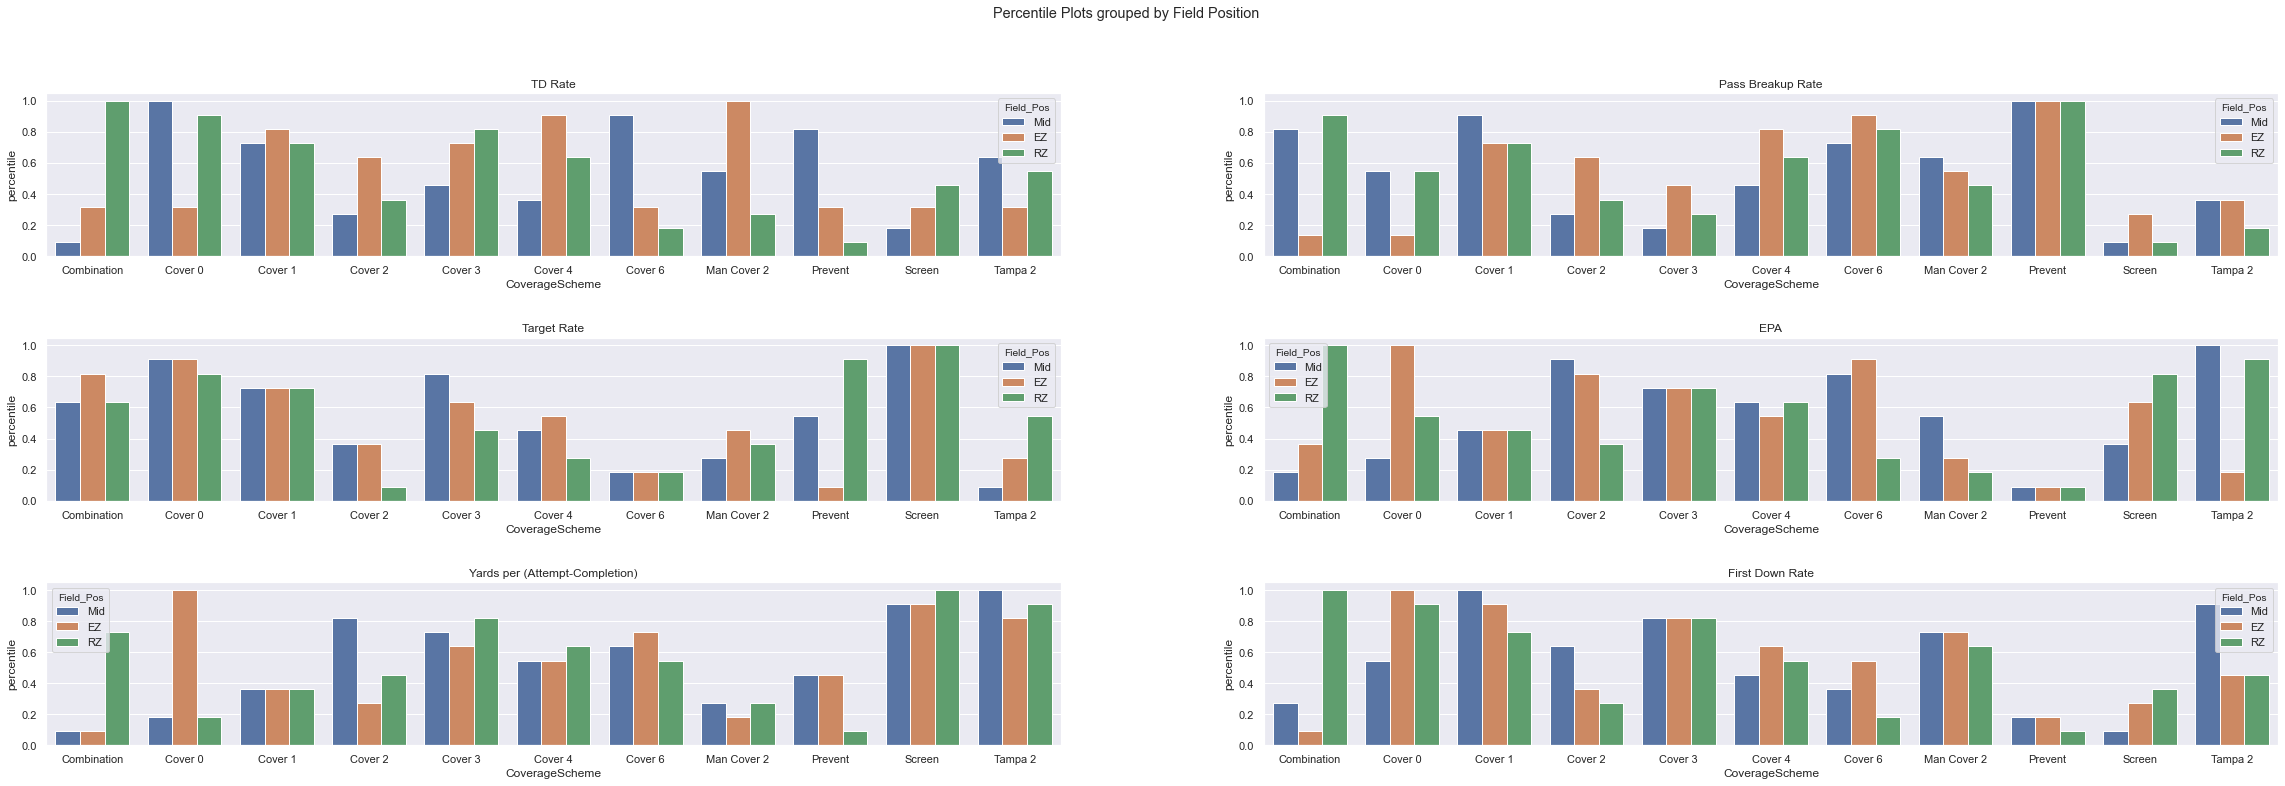

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(40, 12))
fig.suptitle('Percentile Plots grouped by Field Position')

fig.subplots_adjust(hspace=.5)
axes = axes.T.flatten()

sns.barplot(ax=axes[0], data = DF, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[0].set_title('TD Rate')

sns.barplot(ax=axes[1], data = DF2, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[1].set_title('Target Rate')

sns.barplot(ax=axes[2], data = DF3, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[2].set_title('Yards per (Attempt-Completion)')

sns.barplot(ax=axes[3], data = DF4, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[3].set_title('Pass Breakup Rate')

sns.barplot(ax=axes[4], data = DF5, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[4].set_title('EPA');

sns.barplot(ax=axes[5], data = DF6, x='CoverageScheme', y='percentile', hue='Field_Pos')
axes[5].set_title('First Down Rate');

# Expected Yards ML Model

A model which uses random forests regression to estimate the expected yardage on a play for a given coverage scheme

In [27]:
def rf_model(key, full_df):
    
    feats = ['PAA', 'DropType_count', 'archetype_count',
                    'pressure_rate_per_coverage','Running_specialized_route',
                    'target_rate_per_coverage',
                    'breakup_rate_per_coverage',
                    'firstdown_rate_per_coverage',
                    'motion_rate_per_coverage', 
                    'YAC_per_cov','Down', 'ToGo','OSRS', 'DSRS','PD',
                  'route_len_count', 'Route_count', 'RosterPosition_count', 'route_len_list_count', 'Route_list_count', 'personnel_count']
    
    
    X_train, X_test, y_train, y_test = train_test_split(cov_dict[key], 
                                                        cov_dict[key][['OffensiveYardage']], test_size=0.25, random_state=0)
    
    RF= RandomForestRegressor(n_estimators=100,random_state=22)
    
    X_train2 = X_train[feats]
    X_test2 = X_test[feats]

    RF.fit(X_train2,y_train)
    y_pred = RF.predict(X_test2)
    
    print(key)
    print("Train Score:",RF.score(X_train2, y_train))
    print("MAE:",mean_absolute_error(y_pred, y_test))
    print('')
    
    X_test = pd.DataFrame(X_test, columns = X_test.columns)
    X_test.reset_index(inplace=True)
    
    y_pred = pd.DataFrame(y_pred, columns = ['ExpectedYards'])
    df_plot = pd.concat([X_test, y_pred], axis=1)

    return df_plot

In [28]:
df1 = rf_model('Combination', full_df)
df2 = rf_model('Cover 0',  full_df)
df3 = rf_model('Cover 1',  full_df)
df4 = rf_model('Cover 2',  full_df)
df5 = rf_model('Cover 3',  full_df)
df6 = rf_model('Cover 4',  full_df)
df7 = rf_model('Cover 6',  full_df)
df8 = rf_model('Man Cover 2',  full_df)
df9 = rf_model('Prevent',  full_df)
df10 = rf_model('Tampa 2',  full_df)

Combination
Train Score: 0.9915290946107232
MAE: 1.1450862068965515

Cover 0
Train Score: 0.9711089257647851
MAE: 1.8264559386973183

Cover 1
Train Score: 0.9798788212409073
MAE: 2.2236301760902464

Cover 2
Train Score: 0.9840667855250379
MAE: 1.5746124915483433

Cover 3
Train Score: 0.9750835307279606
MAE: 2.4186005831738395

Cover 4
Train Score: 0.983278385847965
MAE: 1.986392430682048

Cover 6
Train Score: 0.989011299691061
MAE: 1.489425925925926

Man Cover 2
Train Score: 0.9874416337130437
MAE: 1.5678669089650397

Prevent
Train Score: 0.9894479534721728
MAE: 1.7852173913043479

Tampa 2
Train Score: 0.9912235496597944
MAE: 1.7441645885286783



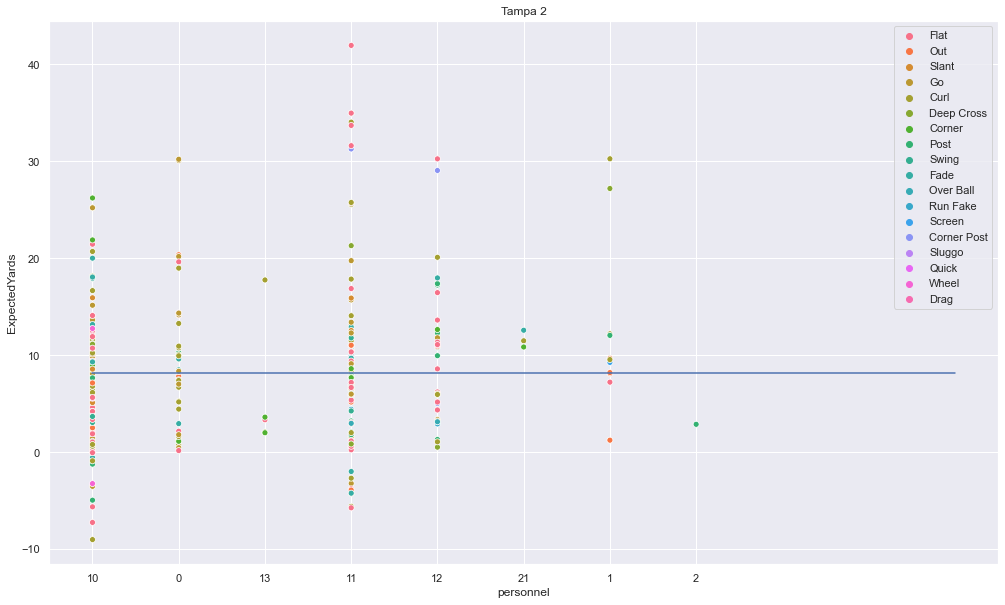

In [29]:
sns.scatterplot(data=df10, x="personnel", y='ExpectedYards', hue = df10['Route'].tolist())
plt.plot([0, 10],2*[np.mean(df10['ExpectedYards'])])
plt.title('Tampa 2');

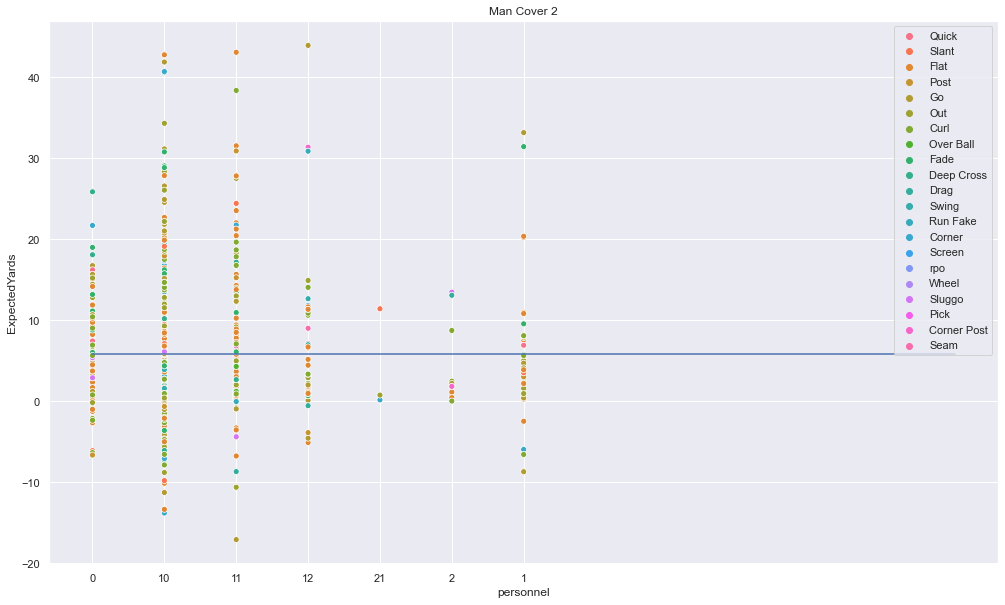

In [30]:
sns.scatterplot(data=df8, x="personnel", y='ExpectedYards', hue = df8['Route'].tolist())
plt.plot([0, 12],2*[np.mean(df8['ExpectedYards'])])
plt.title('Man Cover 2');

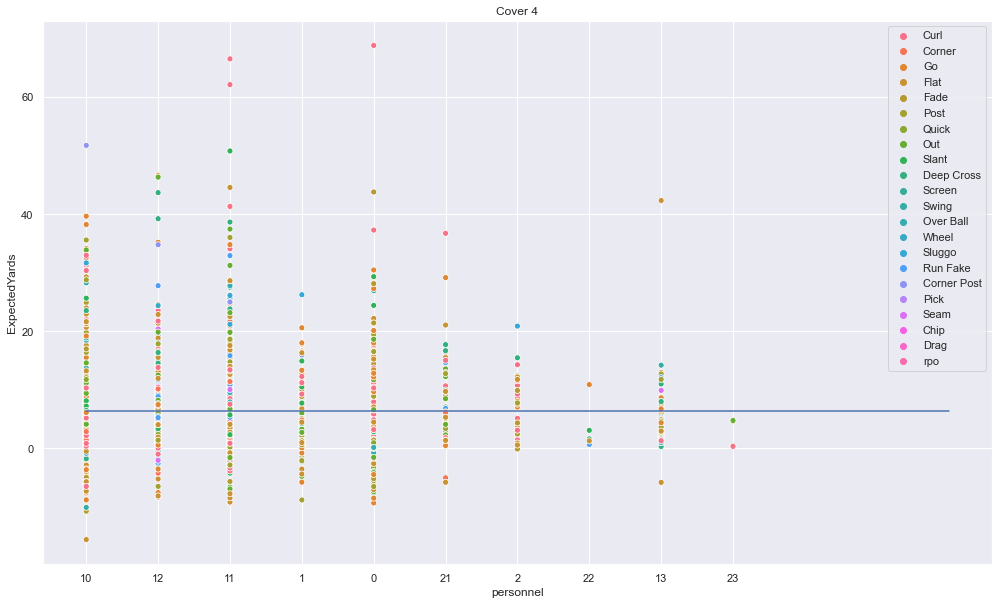

In [31]:
sns.scatterplot(data=df6, x="personnel", y='ExpectedYards', hue = df6['Route'].tolist())
plt.plot([0, 12],2*[np.mean(df6['ExpectedYards'])])
plt.title('Cover 4');

In [57]:
print('Combination')
print(df1.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[4])
print('Cover 0')
print(df2.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[3])
print('Cover 1')
print(df3.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[3])
print('Cover 2')
print(df4.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[5])
print('Cover 3')
print(df5.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[3])
print('Cover 4')
print(df6.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[3])
print('Cover 6')
print(df7.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[0])
print('Man Cover 2')
print(df8.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[4])
print('Prevent')
print(df9.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[1])
print('Tampa 2')
print(df10.groupby(['Route_list'])['ExpectedYards'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[0])

Combination
mean     10.08
count     3.00
Name: ['Corner', 'Curl', 'Fade', 'Out', 'Slant'], dtype: float64
Cover 0
mean     4.415
count    6.000
Name: ['Corner', 'Flat', 'Flat', 'Slant'], dtype: float64
Cover 1
mean      3.9552
count    25.0000
Name: ['Curl', 'Curl', 'Curl', 'Flat', 'Flat'], dtype: float64
Cover 2
mean     10.422222
count     9.000000
Name: ['Curl', 'Curl', 'Curl', 'Flat', 'Go'], dtype: float64
Cover 3
mean      5.218485
count    33.000000
Name: ['Curl', 'Curl', 'Flat', 'Flat', 'Go'], dtype: float64
Cover 4
mean      6.62
count    20.00
Name: ['Curl', 'Curl', 'Curl', 'Flat', 'Go'], dtype: float64
Cover 6
mean     12.553
count    10.000
Name: ['Curl', 'Flat', 'Flat', 'Go', 'Out'], dtype: float64
Man Cover 2
mean     6.65625
count    8.00000
Name: ['Flat', 'Flat', 'Go', 'Out', 'Slant'], dtype: float64
Prevent
mean     12.076
count     5.000
Name: ['Go', 'Go', 'Go', 'Go', 'Go'], dtype: float64
Tampa 2
mean     16.147273
count    11.000000
Name: ['Curl', 'Curl', 'Curl', 'F

# First Down Prediction ML Model

A model which predicts the probability of a first down on a given play for a given coverage scheme

In [58]:
def log_regress_model(key):
    
    feats = ['pressure_rate_per_coverage','StartYard', 'Hash',
                    'target_rate_per_coverage','archetype_count','DropType_count',
                    'breakup_rate_per_coverage',
                    'firstdown_rate_per_coverage',
                    'motion_rate_per_coverage', 
                    'YAC_per_cov','Down', 'ToGo','OSRS', 'DSRS','PD',
                  'PAA', 'route_len_count', 'Route_count', 
                    'PressureOnPlay','RPO', 'Shotgun', 'ThrowDepth','Running_specialized_route', 'route_len_list_count', 'Route_list_count']
    
    X = cov_dict[key]
    
    X_train, X_test, y_train, y_test = train_test_split(X, cov_dict[key][['FirstDown']], test_size=0.25, random_state=0)
    
    scaler = MinMaxScaler(feature_range = (0,1))
    
    X_train2 = X_train[feats]
    X_test2 = X_test[feats]

    scaler.fit(X_train2)
    X_train2 = scaler.transform(X_train2)
    X_test2 = scaler.transform(X_test2)
    
    clf = DecisionTreeClassifier(class_weight = 'balanced').fit(X_train2, y_train)
    print(key)
    print(' ')
    print('Train Score: ' + str(clf.score(X_train2, y_train)))
    
    y_pred = clf.predict(X_test2)
    
    cm = confusion_matrix(y_test, y_pred)

    print('Balanced Accuracy: ' + str(100*balanced_accuracy_score(y_pred, y_test)) + '%')
    print('Accuracy: ' + str(100*accuracy_score(y_pred, y_test)) + '%')
    print(' ')
    print('Confusion Matrix:')
    print(cm)
    print(' ')
    
    probs = pd.DataFrame(clf.predict_proba(X_test2), columns = ['Probability_No_First_down', 'Probability_First_down'])
    X_test = pd.DataFrame(X_test)
    
    probs_with_feats = X_test.merge(probs, on = X_test.index)

    return probs_with_feats 


In [59]:
probs = log_regress_model('Combination')
probs2 = log_regress_model('Cover 0')
probs3 = log_regress_model('Cover 1')
probs4= log_regress_model('Cover 2')
probs5 = log_regress_model('Cover 3')
probs6 = log_regress_model('Cover 4')
probs7 = log_regress_model('Cover 6')
probs8 = log_regress_model('Man Cover 2')
probs9 = log_regress_model('Prevent')
probs10 = log_regress_model('Tampa 2')

Combination
 
Train Score: 1.0
Balanced Accuracy: 97.48689485044711%
Accuracy: 97.41379310344827%
 
Confusion Matrix:
[[67  1]
 [ 2 46]]
 
Cover 0
 
Train Score: 1.0
Balanced Accuracy: 94.46226809875856%
Accuracy: 95.01915708812261%
 
Confusion Matrix:
[[311  16]
 [ 10 185]]
 
Cover 1
 
Train Score: 1.0
Balanced Accuracy: 98.33947953502398%
Accuracy: 98.43169624432522%
 
Confusion Matrix:
[[2956   38]
 [  38 1814]]
 
Cover 2
 
Train Score: 1.0
Balanced Accuracy: 98.86040280857354%
Accuracy: 98.88438133874239%
 
Confusion Matrix:
[[1298    8]
 [  14  652]]
 
Cover 3
 
Train Score: 1.0
Balanced Accuracy: 98.65546782411394%
Accuracy: 98.72895912057712%
 
Confusion Matrix:
[[3631   35]
 [  39 2117]]
 
Cover 4
 
Train Score: 1.0
Balanced Accuracy: 98.15170715336714%
Accuracy: 98.5124468731026%
 
Confusion Matrix:
[[2243   29]
 [  20 1002]]
 
Cover 6
 
Train Score: 1.0
Balanced Accuracy: 99.14285714285714%
Accuracy: 99.44444444444444%
 
Confusion Matrix:
[[365   3]
 [  0 172]]
 
Man Cover 2


In [75]:
print('Combination')
print(probs.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[4])
print('Cover 0')
print(probs2.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[2])
print('Cover 1')
print(probs3.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[2])
print('Cover 2')
print(probs4.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[0])
print('Cover 3')
print(probs5.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[2])
print('Cover 4')
print(probs6.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[3])
print('Cover 6')
print(probs7.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[0])
print('Man Cover 2')
print(probs8.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[4])
print('Prevent')
print(probs9.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[2])
print('Tampa 2')
print(probs10.groupby(['Route_list'])['Probability_First_down'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).iloc[0])

Combination
mean     1.0
count    3.0
Name: ['Corner', 'Curl', 'Fade', 'Out', 'Slant'], dtype: float64
Cover 0
mean     0.833333
count    6.000000
Name: ['Corner', 'Flat', 'Flat', 'Out'], dtype: float64
Cover 1
mean      0.615385
count    26.000000
Name: ['Flat', 'Flat', 'Flat', 'Go', 'Out'], dtype: float64
Cover 2
mean      0.619048
count    21.000000
Name: ['Curl', 'Curl', 'Curl', 'Flat', 'Flat'], dtype: float64
Cover 3
mean      0.545455
count    44.000000
Name: ['Curl', 'Flat', 'Flat', 'Flat', 'Go'], dtype: float64
Cover 4
mean      0.35
count    20.00
Name: ['Curl', 'Curl', 'Curl', 'Flat', 'Go'], dtype: float64
Cover 6
mean      0.7
count    10.0
Name: ['Curl', 'Flat', 'Flat', 'Go', 'Out'], dtype: float64
Man Cover 2
mean     0.625
count    8.000
Name: ['Flat', 'Flat', 'Go', 'Out', 'Slant'], dtype: float64
Prevent
mean     1.0
count    4.0
Name: ['Corner', 'Flat', 'Go', 'Out', 'Post'], dtype: float64
Tampa 2
mean      0.636364
count    11.000000
Name: ['Curl', 'Curl', 'Curl', 'Fla

# END